# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers

image_width = image_height = 128
image_channels = 3 # RGB
data_frame_labels = ['Age', 'Gender', 'Filenames']

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
#
# Add your code here
#
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
content_dir = "/content/drive/MyDrive/ML2CW1/"

In [3]:
# Load data locally
#### remove before submission
content_dir = '/home/daniel/ML1Labs/ML2/CW1/'

In [4]:
image_dir = content_dir + "train_val/"
file_names = listdir(image_dir)

image_paths = list(map(lambda x : image_dir + x, file_names))

labels = []
for name in file_names:
  label = name.split("_")[:2]
  labels.append(label)

## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

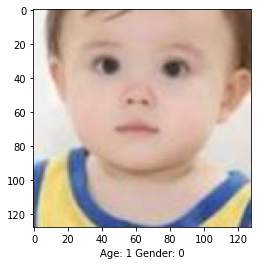

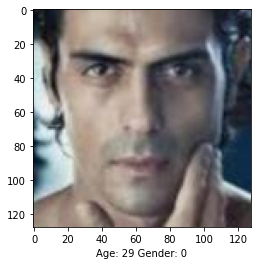

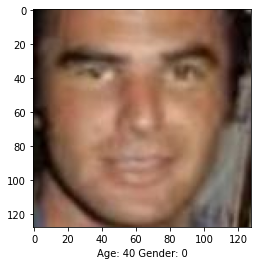

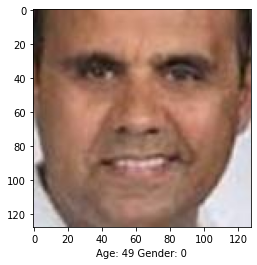

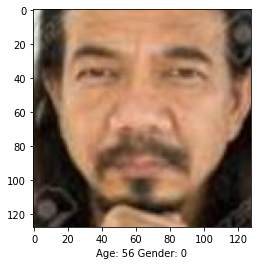

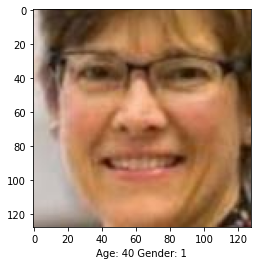

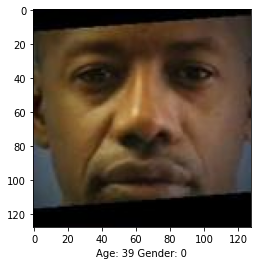

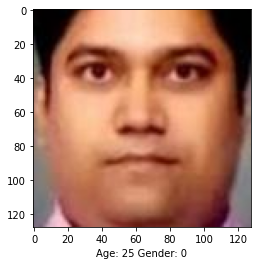

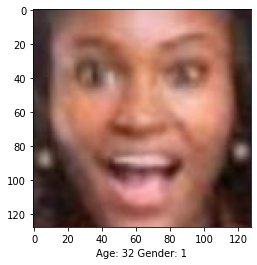

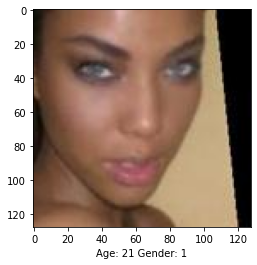

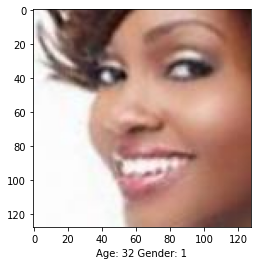

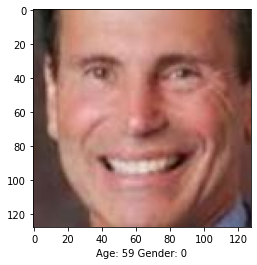

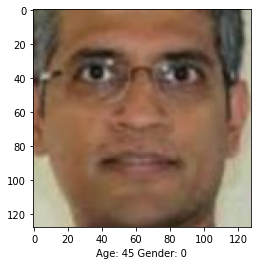

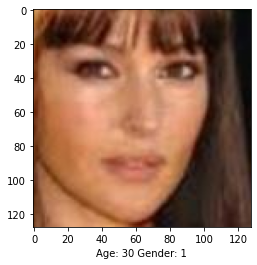

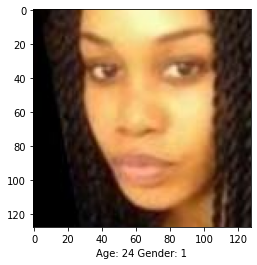

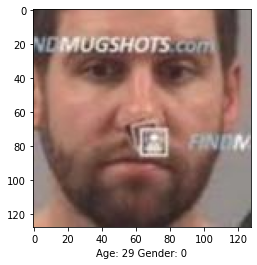

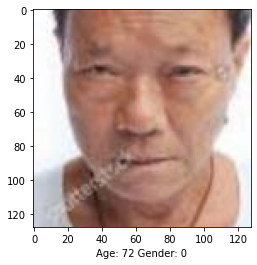

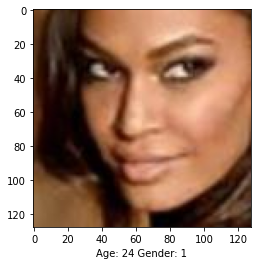

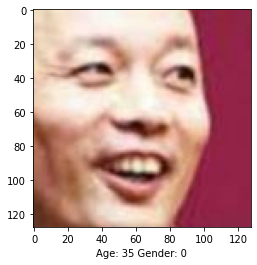

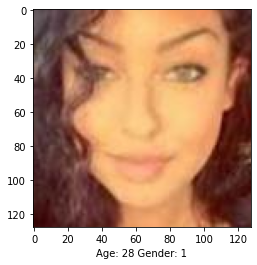

In [5]:
imgs_to_show = []
num_images = 20

random_image_paths = random.sample(image_paths, num_images)

for i in range(num_images):
  imgs_to_show.append(mpimg.imread(random_image_paths[i]))

axes=[]

for i in range(20):
  image = imgs_to_show[i]
  label = random_image_paths[i].split("/")[-1].split("_")[:2]
  fig = plt.figure()
  plt.xlabel("Age: " + label[0] + " Gender: " + label[1])
  plt.imshow(image)

plt.show()

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [6]:
#
# Add your code here
#
import pandas as pd

# ages = [np.asarray(item[0]).astype(float) for item in labels]
# genders = [np.asarray(item[1]).astype(float) for item in labels]
# data = np.array([image_paths, ages, genders]).T
# df = pd.DataFrame(data = data, columns = data_frame_labels)

records = []
for l_age, l_gender in labels:
  records.append((int(l_age), int(l_gender)))
df = pd.DataFrame(records)
df['Filenames'] = image_paths
df.columns = data_frame_labels

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

In [7]:
#
# Add your code here
#

image_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.1, horizontal_flip=True, validation_split = 0.2)
train_generator = image_datagen.flow_from_dataframe(df, x_col=data_frame_labels[-1], y_col=data_frame_labels[:-1], target_size=(image_width,image_height), color_mode='rgb', class_mode='multi_output', subset='training', batch_size=32)
validation_generator = image_datagen.flow_from_dataframe(df, x_col=data_frame_labels[-1], y_col=data_frame_labels[:-1], target_size=(image_width,image_height), color_mode='rgb', class_mode='multi_output', subset='validation', batch_size=32)

print(train_generator.n, train_generator.batch_size, train_generator.n // train_generator.batch_size)
print(validation_generator.n, validation_generator.batch_size, validation_generator.n // validation_generator.batch_size)


Found 4000 validated image filenames.
Found 1000 validated image filenames.
4000 32 125
1000 32 31


In [8]:
# def train_gen_wrapped():
#   batch = train_generator.next()
#   casted = (np.array(batch[0]), np.array([[int(float(item[0])), int(float(item[1]))] for item in batch[1][:]]))
#   while True:
#     yield casted

# def val_gen_wrapped():
#   batch = validation_generator.next()
#   casted = (np.array(batch[0]), np.array([[int(float(item[0])), int(float(item[1]))] for item in batch[1][:]]))
#   while True:
#     yield casted

#df


# sample_set_x = sample[0]
# sample_set_y = sample[1]

# num_batches = 100
# for i in range(num_batches):
#     sample = next(train_gen_wrapped())
# #sample[1]
#     sample_x = sample[0]
#     sample_y = sample[1]
#     np.concatenate((sample_set_x, sample_x))
#     np.concatenate((sample_set_y, sample_y))



# print(sample_set_x.shape)
# print('X',sample_set_x)
# print('Y', sample_set_y.shape)

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

In [32]:
#
# Add your code here
#

# Can only really tune hyper-params, everything-else is managed by Keras.
# Hyper-params:
# - Kernel Size (1st layer must be 10x10 or smaller)
# - Number of Layers (Tho kinda dependent on kernal sizes? Must also be reasonable, pressume nothing crazy like 100 layers...)
# - Activation Function (probably some variation on ReLU, e.g. LeakyReLU)
# - Pooling Layers (Where to use, e.g. between each layer, or spread-out a bit)
# - Number of 'Features', e.g. how many kernals for a given layer
# - Using Single Layer & Kernel Size Vs Multiple Layers With Smaller Kernels (e.g. one 5x5 is equivilent to two 3x3 layers (with no pooling), latter reduces number of params, but obviously doubles number of layers)
# - Where to branch (e.g. how many layers do we share with each branch: split right away, or at point of classification? Basically how many features reused between branches)
# - 

# Not sure how best to tune the hyper-params to ensure avoid over-fitting to data, e.g. not just re-running with different config over-and-over.

# Train w/ & w/out for comparision w/in the report, see if any actual performance benefits?
#greyscale = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs) # Might want to branch here as colour could be helpful to distinguish grey/white hair from other colours, might be helpful for age branch

# Need one branch for age, other for gender
#   Worth encapsulating into methods to create each branch?

# Conv2d args (at least obviously important ones): https://keras.io/api/layers/convolution_layers/convolution2d/
# tf.keras.layers.Conv2D(
#     filters,     # Number of filters/features, depth of next layer
#     kernel_size, # Can either be int: n for n*n, or (int, int): (n, m) for n*m, can also do additional dimensions, e.g. to try and reduce the depth of prior layers
#     strides=(1, 1),
#     padding="valid",
#     ...
#     activation=None,
#     ...
# )

# MaxPooling2D & AveragePooling2D args: https://keras.io/api/layers/pooling_layers/max_pooling2d/  https://keras.io/api/layers/pooling_layers/average_pooling2d/
# tf.keras.layers.MaxPooling2D/AveragePooling2D(
#     pool_size=(2, 2), 
#     strides=None, 
#     padding="valid", 
#     ...
# )

# Layer Dimensions Calculations:
#   new_width  = (old_width - kernel_width + (2 * padding_x)) / (stride_x + 1)
#   new_height = (old_height - kernel_height + (2 * padding_y)) / (stride_y + 1)
#   new_depth  = old_depth # though was also *number_of_features, but seems these arre flattened for each feature

def create_modelA(greyscale):
  inputs = keras.Input((image_width, image_height, image_channels))

  if (greyscale == 2): # only apply greyscale to gender branch 
    gender_inputs = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
    gender_branch = create_modelA_common_layers(gender_inputs)
    gender_branch = create_gender_branch(gender_branch)

    age_branch = create_modelA_common_layers(inputs)
    age_branch = create_age_branch(age_branch)
  else: # greyscale for both or neither branch
    # greyscale for both branches
    greyscale_layer = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs) if greyscale == 1 else inputs
    common_layers = create_modelA_common_layers(inputs)

    gender_branch = create_gender_branch(common_layers)
    age_branch = create_age_branch(common_layers)

  # Creating 1 model w/ two branches per https://pyimagesearch.com/2018/06/04/keras-multiple-outputs-and-multiple-losses/
  return keras.Model(inputs=inputs, outputs=[age_branch, gender_branch], name="ModelA")

def create_modelA_common_layers(inputs):
  
    common_layers = layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3))(inputs) # 124, 124, 512
    common_layers = layers.Conv2D(64, (3, 3), activation='relu')(common_layers)
    common_layers = layers.MaxPooling2D((2,2))(common_layers) # 50, 50, 1024
    common_layers = layers.BatchNormalization(axis = 3)(common_layers)
    
    
    common_layers = layers.Conv2D(128, (3, 3), activation='relu')(common_layers) # 124, 124, 512
    common_layers = layers.MaxPooling2D((2,2))(common_layers) # 50, 50, 1024

    #common_layers = layers.Flatten()(common_layers)

#   common_layers_a = layers.Conv2D(64, 5)(common_layers) # 46, 46, 64
  
#   common_layers_b = layers.Conv2D(64, 9)(common_layers) # 42, 42, 64
#   common_layers_b = layers.LeakyReLU(0.2)(common_layers_b)

#   common_layers = layers.Add()([common_layers_a, common_layers_b])
#   common_layers = layers.BatchNormalization(axis=1)(common_layers)

#   common_layers = layers.MaxPooling2D((7,7), (4,4))(common_layers) # 9, 9, 64
#   # common_layers = layers.Conv2D(128, 3)(common_layers) # 7, 7, 128
  
#   common_layers_c = layers.Conv2D(128, 3, padding='same')(common_layers) # 7, 7, 128 # padding to keep output same size as input
#   common_layers_c = layers.LeakyReLU(0.2)(common_layers_c)
#   common_layers_c = layers.Conv2D(64, 3, padding='same')(common_layers_c) # 7, 7, 64
#   common_layers_c = layers.LeakyReLU(0.2)(common_layers_c)
#   common_layers_c = layers.Conv2D(64, 3, padding='same')(common_layers_c) # 7, 7, 64
#   common_layers_c = layers.LeakyReLU(0.2)(common_layers_c)
#   common_layers_c = layers.Conv2D(32, 3, padding='same')(common_layers_c) # 7, 7, 32
#   common_layers_c = layers.BatchNormalization(axis=1)(common_layers_c)

#   common_layers_d = layers.Conv2D(128, 3, padding='same')(common_layers) # 7, 7, 128 # padding to keep output same size as input
#   common_layers_d = layers.LeakyReLU(0.2)(common_layers_d)
#   common_layers_d = layers.Conv2D(32, 3, padding='same')(common_layers_d) # 7, 7, 32
#   common_layers_d = layers.BatchNormalization(axis=1)(common_layers_d) 
  
#   common_layers = layers.Add()([common_layers_c, common_layers_d])
#   common_layers = layers.GlobalAveragePooling2D()(common_layers)

    return common_layers

# Probably just need fully connected layers here, no more convolutions?
def create_gender_branch(inputs):    
    gender_branch = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
#     gender_branch = layers.MaxPooling2D((2,2))(gender_branch) # 50, 50, 1024
#     gender_branch = layers.BatchNormalization(axis = 3)(gender_branch)
    
    #gender_branch = layers.Conv2D(64, (3, 3), activation='relu')(gender_branch)
    gender_branch = layers.MaxPooling2D((2,2))(gender_branch) # 50, 50, 1024
    gender_branch = layers.BatchNormalization()(gender_branch)
    
    gender_branch = layers.Conv2D(128, (2, 2), activation='relu')(gender_branch)
    gender_branch = layers.MaxPooling2D((2,2))(gender_branch) # 50, 50, 1024
    gender_branch = layers.BatchNormalization()(gender_branch) 
    
    #gender_branch = layers.Flatten()(gender_branch)
    
    gender_branch = layers.Conv2D(1, (2, 2), activation='relu')(gender_branch)
    gender_branch = layers.Flatten()(gender_branch)
    
    gender_branch = layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01))(gender_branch)
    gender_branch = layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01))(gender_branch)
    gender_branch = layers.Dense(1, name='gender_output')(gender_branch)

    return gender_branch

def create_age_branch(inputs):
    age_branch = layers.Conv2D(64, (3, 3), activation='relu')(inputs)
#     age_branch = layers.MaxPooling2D((2,2))(age_branch) # 50, 50, 1024
#     age_branch = layers.BatchNormalization(axis = 3)(age_branch)
    #age_branch = layers.Flatten()(age_branch)
    
    #age_branch = layers.Conv2D(64, (3, 3), activation='relu')(age_branch)
    age_branch = layers.MaxPooling2D((2,2))(age_branch) # 50, 50, 1024
    age_branch = layers.BatchNormalization(axis = 3)(age_branch)
    #age_branch = layers.Flatten()(age_branch)
    
    age_branch = layers.Conv2D(128, (2, 2), activation='relu')(age_branch)
    age_branch = layers.MaxPooling2D((2,2))(age_branch) # 50, 50, 1024
    age_branch = layers.BatchNormalization(axis = 3)(age_branch)
    #age_branch = layers.Flatten()(age_branch)
    
    age_branch = layers.Conv2D(1, (2, 2), activation='relu')(age_branch)
    age_branch = layers.Flatten()(age_branch)
    
    age_branch = layers.Dense(128, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01))(age_branch)
    age_branch = layers.Dense(16, activation='relu', activity_regularizer=tf.keras.regularizers.l2(0.01))(age_branch)
    age_branch = layers.Dense(1, name='age_output')(age_branch)

    return age_branch

modelA = create_modelA(0)

modelA.summary()
from keras.utils.vis_utils import plot_model
plot_model(modelA, show_shapes=True)

Model: "ModelA"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_116 (Conv2D)            (None, 126, 126, 64  1792        ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_117 (Conv2D)            (None, 124, 124, 64  36928       ['conv2d_116[0][0]']             
                                )                                                            

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [36]:
#
# Add your code here
#

losses = {
	"age_output": keras.losses.MeanSquaredError(),
  "gender_output": keras.losses.BinaryCrossentropy(from_logits = True)
}
loss_weight = {
	"age_output": 1.0,
    "gender_output": 50.0
}

metrics= {
  "age_output": keras.metrics.MeanAbsoluteError(),
  "gender_output": keras.metrics.BinaryAccuracy()
}

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

# compile model
modelA_compiled = modelA.compile(loss=losses, loss_weights = loss_weight, optimizer=keras.optimizers.Adam(learning_rate=lr_schedule), metrics=metrics)
print("Compiling Model A")

modelA_epoch_count = 50 # ?
modelA_train_steps_per_epoch = train_generator.n // train_generator.batch_size
modelA_val_steps_per_epoch = validation_generator.n // validation_generator.batch_size

print("training steps per epoch: {}\nvalidation steps per epoch: {}".format(modelA_train_steps_per_epoch, modelA_val_steps_per_epoch))

print("Fitting Model A")
modelA_history = modelA.fit(
    x = train_generator,
    validation_data=validation_generator,
    epochs=modelA_epoch_count,
    steps_per_epoch=modelA_train_steps_per_epoch,
    validation_steps=modelA_val_steps_per_epoch
)

modelA.save(content_dir+"age_gender_A_3.h5")

Compiling Model A
training steps per epoch: 125
validation steps per epoch: 31
Fitting Model A
Epoch 1/50
125/125 [==============================] - 13s 94ms/step - loss: 506.7446 - age_output_loss: 429.0347 - gender_output_loss: 0.6464 - age_output_mean_absolute_error: 15.8000 - gender_output_binary_accuracy: 0.6058 - val_loss: 555.1848 - val_age_output_loss: 482.6824 - val_gender_output_loss: 0.6503 - val_age_output_mean_absolute_error: 16.3961 - val_gender_output_binary_accuracy: 0.5806
Epoch 2/50
125/125 [==============================] - 11s 90ms/step - loss: 386.9292 - age_output_loss: 320.2104 - gender_output_loss: 0.5539 - age_output_mean_absolute_error: 13.7570 - gender_output_binary_accuracy: 0.6992 - val_loss: 2050.6833 - val_age_output_loss: 1940.1958 - val_gender_output_loss: 0.6103 - val_age_output_mean_absolute_error: 38.9678 - val_gender_output_binary_accuracy: 0.6764
Epoch 3/50
125/125 [==============================] - 11s 90ms/step - loss: 352.8638 - age_output_loss:

125/125 [==============================] - 12s 92ms/step - loss: 177.3720 - age_output_loss: 133.9080 - gender_output_loss: 0.3893 - age_output_mean_absolute_error: 8.6397 - gender_output_binary_accuracy: 0.8155 - val_loss: 209.0002 - val_age_output_loss: 164.7043 - val_gender_output_loss: 0.4101 - val_age_output_mean_absolute_error: 8.9872 - val_gender_output_binary_accuracy: 0.8044
Epoch 22/50
125/125 [==============================] - 12s 92ms/step - loss: 181.6040 - age_output_loss: 137.2522 - gender_output_loss: 0.4003 - age_output_mean_absolute_error: 8.6735 - gender_output_binary_accuracy: 0.8095 - val_loss: 284.9022 - val_age_output_loss: 237.6010 - val_gender_output_loss: 0.4459 - val_age_output_mean_absolute_error: 10.9348 - val_gender_output_binary_accuracy: 0.7712
Epoch 23/50
125/125 [==============================] - 12s 95ms/step - loss: 185.2352 - age_output_loss: 142.0386 - gender_output_loss: 0.3869 - age_output_mean_absolute_error: 8.8585 - gender_output_binary_accura

Epoch 42/50
125/125 [==============================] - 12s 92ms/step - loss: 147.2016 - age_output_loss: 109.6429 - gender_output_loss: 0.3379 - age_output_mean_absolute_error: 7.6800 - gender_output_binary_accuracy: 0.8425 - val_loss: 215.2832 - val_age_output_loss: 167.9246 - val_gender_output_loss: 0.4477 - val_age_output_mean_absolute_error: 8.8684 - val_gender_output_binary_accuracy: 0.8175
Epoch 43/50
125/125 [==============================] - 12s 92ms/step - loss: 149.7033 - age_output_loss: 113.2692 - gender_output_loss: 0.3280 - age_output_mean_absolute_error: 7.8229 - gender_output_binary_accuracy: 0.8430 - val_loss: 176.8162 - val_age_output_loss: 131.3535 - val_gender_output_loss: 0.4206 - val_age_output_mean_absolute_error: 7.9761 - val_gender_output_binary_accuracy: 0.8196
Epoch 44/50
125/125 [==============================] - 12s 92ms/step - loss: 141.8237 - age_output_loss: 105.5894 - gender_output_loss: 0.3264 - age_output_mean_absolute_error: 7.5419 - gender_output_bi

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


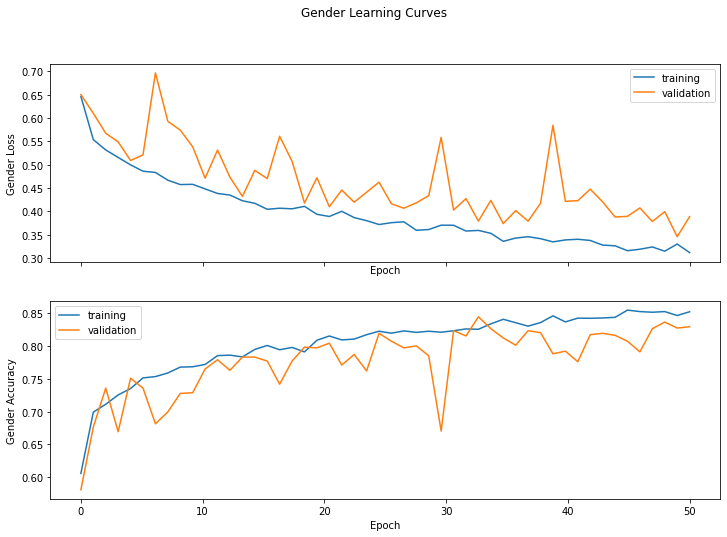

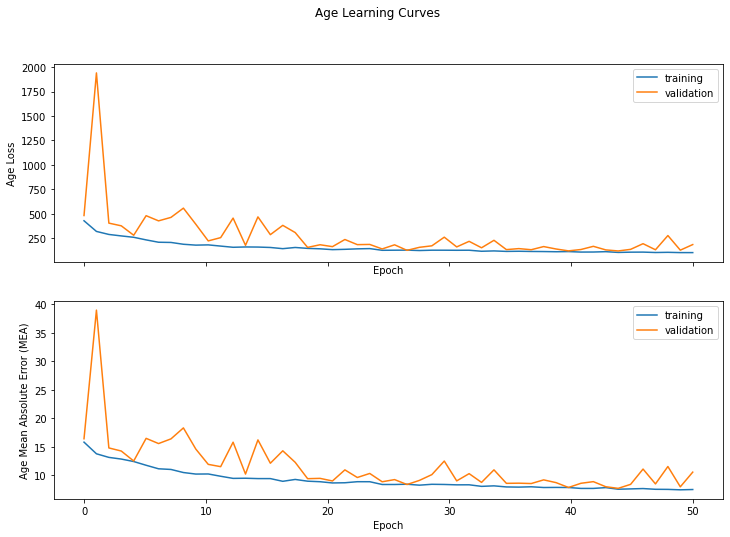

In [37]:
#
# Add your code here
#
epochs = np.linspace(0, modelA_epoch_count, modelA_epoch_count)

fig, (gender_loss, gender_accuracy) = plt.subplots(2, sharex=True)
fig.suptitle("Gender Learning Curves")
fig.set_size_inches(12,8)

gender_loss.set_xlabel("Epoch")
gender_loss.set_ylabel("Gender Loss")
gender_loss.plot(epochs, modelA_history.history['gender_output_loss'], label='training')
gender_loss.plot(epochs, modelA_history.history['val_gender_output_loss'], label='validation')
gender_loss.legend()

gender_accuracy.set_xlabel("Epoch")
gender_accuracy.set_ylabel("Gender Accuracy")
gender_accuracy.plot(epochs, modelA_history.history['gender_output_binary_accuracy'], label='training')
gender_accuracy.plot(epochs, modelA_history.history['val_gender_output_binary_accuracy'], label='validation')
gender_accuracy.legend()

plt.show()

fig, (age_loss, age_mae) = plt.subplots(2, sharex=True)
fig.suptitle("Age Learning Curves")
fig.set_size_inches(12,8)

age_loss.set_xlabel("Epoch")
age_loss.set_ylabel("Age Loss")
age_loss.plot(epochs, modelA_history.history['age_output_loss'], label='training')
age_loss.plot(epochs, modelA_history.history['val_age_output_loss'], label='validation')
age_loss.legend()

age_mae.set_xlabel("Epoch")
age_mae.set_ylabel("Age Mean Absolute Error (MEA)")
age_mae.plot(epochs, modelA_history.history['age_output_mean_absolute_error'], label='training')
age_mae.plot(epochs, modelA_history.history['val_age_output_mean_absolute_error'], label='validation')
age_mae.legend()

plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


In [39]:
#
# Add your code here
#

# list of available models: https://keras.io/api/applications/
import tensorflow.keras.applications.resnet50 as ResNet50 # quick, lighweight, and fairly accurate  

inputs_b = keras.Input((image_width, image_height, image_channels))
base_resnet50 = ResNet50.ResNet50(input_tensor=inputs_b, weights='imagenet', include_top=False)

globalPool = layers.GlobalAveragePooling2D()(base_resnet50.output)

#gender_branch = create_gender_branch(globalPool)
#age_branch = create_age_branch(globalPool)

gender_branch = layers.Dense(256, activation='relu')(globalPool)
gender_branch = layers.Dense(16, activation='relu')(gender_branch)
gender_branch = layers.Dense(1, name='gender_output')(gender_branch)

age_branch = layers.Dense(256, activation='relu')(globalPool)
age_branch = layers.Dense(16, activation='relu')(age_branch)
age_branch = layers.Dense(1, name='age_output')(age_branch)

modelB = keras.Model(inputs=base_resnet50.inputs, outputs=[age_branch, gender_branch])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_8[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']       

 conv2_block3_2_conv (Conv2D)   (None, 32, 32, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 32, 32, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 32, 32, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 32, 32, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_blo

 conv3_block3_2_conv (Conv2D)   (None, 16, 16, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 16, 16, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 16, 16, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 16, 16, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_blo

 conv4_block2_2_conv (Conv2D)   (None, 8, 8, 256)    590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 8, 8, 256)   1024        ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block2_2_relu[0][0]']    
                                                                                                  
 conv4_blo

 conv4_block5_2_relu (Activatio  (None, 8, 8, 256)   0           ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 8, 8, 1024)   263168      ['conv4_block5_2_relu[0][0]']    
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 8, 8, 1024)  4096        ['conv4_block5_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_add (Add)         (None, 8, 8, 1024)   0           ['conv4_block4_out[0][0]',       
                                                                  'conv4_block5_3_bn[0][0]']      
          

 conv5_block2_2_relu (Activatio  (None, 4, 4, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 4, 4, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 4, 4, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 4, 4, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
          

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [40]:
#
# Add your code here
#
losses = {
  "age_output": keras.losses.MeanAbsoluteError(),
	"gender_output": keras.losses.BinaryFocalCrossentropy(from_logits = True)
}
loss_weight = {
	"age_output": 0.25,
    "gender_output": 10.0
}
metrics= {
  "age_output": keras.metrics.MeanAbsoluteError(),
  "gender_output": keras.metrics.BinaryAccuracy()
}

modelB_compiled = modelB.compile(loss=losses, loss_weights = loss_weight, optimizer='adam', metrics=metrics)
print("Compiling Model B")

modelB_epoch_count = 50 # ?
modelB_train_steps_per_epoch = train_generator.n // train_generator.batch_size
modelB_val_steps_per_epoch = validation_generator.n // validation_generator.batch_size

modelB_history = modelB.fit(
    x=train_generator,
    validation_data=validation_generator,
    epochs=modelB_epoch_count,
    steps_per_epoch=modelB_train_steps_per_epoch,
    validation_steps=modelB_val_steps_per_epoch
)

modelB.save(content_dir+"age_gender_B.h5")

Compiling Model B
Epoch 1/50
28/80 [=========>....................] - ETA: 9s - loss: 5.2357 - age_output_loss: 14.6345 - gender_output_loss: 0.1577 - age_output_mean_absolute_error: 14.6345 - gender_output_binary_accuracy: 0.6379

KeyboardInterrupt: 

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

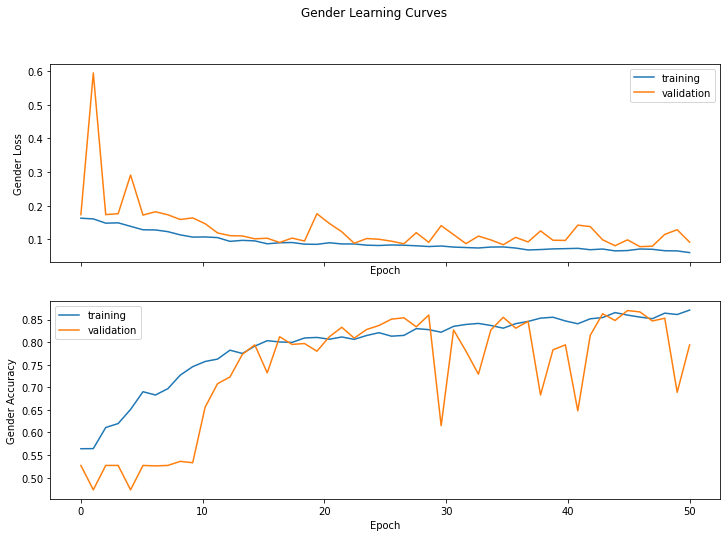

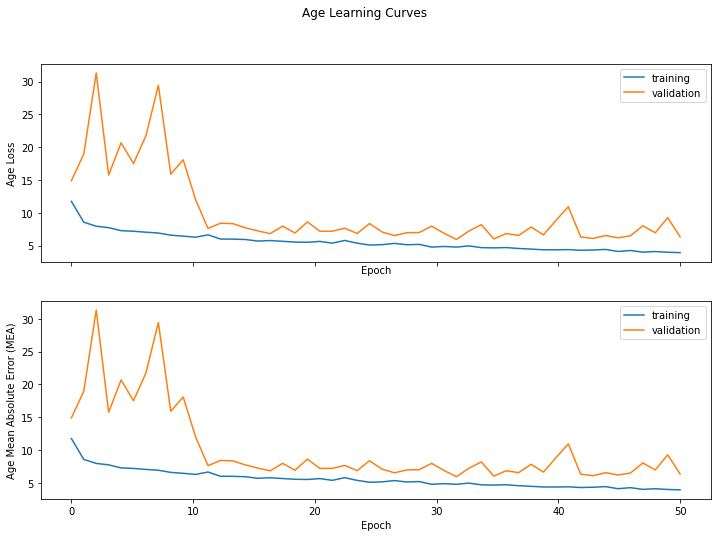

In [25]:
#
# Add your code here
#
epochs = np.linspace(0, modelB_epoch_count, modelB_epoch_count)

fig, (gender_loss, gender_accuracy) = plt.subplots(2, sharex=True)
fig.suptitle("Gender Learning Curves")
fig.set_size_inches(12,8)

gender_loss.set_xlabel("Epoch")
gender_loss.set_ylabel("Gender Loss")
gender_loss.plot(epochs, modelB_history.history['gender_output_loss'], label='training')
gender_loss.plot(epochs, modelB_history.history['val_gender_output_loss'], label='validation')
gender_loss.legend()

gender_accuracy.set_xlabel("Epoch")
gender_accuracy.set_ylabel("Gender Accuracy")
gender_accuracy.plot(epochs, modelB_history.history['gender_output_binary_accuracy'], label='training')
gender_accuracy.plot(epochs, modelB_history.history['val_gender_output_binary_accuracy'], label='validation')
gender_accuracy.legend()

plt.show()

fig, (age_loss, age_mae) = plt.subplots(2, sharex=True)
fig.suptitle("Age Learning Curves")
fig.set_size_inches(12,8)

age_loss.set_xlabel("Epoch")
age_loss.set_ylabel("Age Loss")
age_loss.plot(epochs, modelB_history.history['age_output_loss'], label='training')
age_loss.plot(epochs, modelB_history.history['val_age_output_loss'], label='validation')
age_loss.legend()

age_mae.set_xlabel("Epoch")
age_mae.set_ylabel("Age Mean Absolute Error (MEA)")
age_mae.plot(epochs, modelB_history.history['age_output_mean_absolute_error'], label='training')
age_mae.plot(epochs, modelB_history.history['val_age_output_mean_absolute_error'], label='validation')
age_mae.legend()

plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#